## EE-UY 4563/EL-GY 9123: Introduction to machine learning
Ernesto Akio Yoshimoto

N12949891

Lab #5

# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

$$\hat{y} = g(x,w)$$
     
where $w$ is a vector of paramters and $x$ is the vector of predictors.  We find $w$ by minimizing a least-squares function 

$$f(w) = \sum_i (y_i - g(x_i,w))^2$$
     
where the summation is over training samples $(x_i,y_i)$.  This is similar to linear least-squares, but the function $g(x,w)$ may not be linear in $w$.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

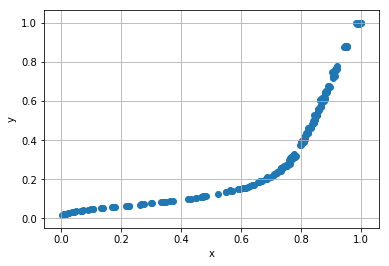

In [3]:
# TODO
# x0 = ...
x0 = np.array(df.iloc[:,0])
# y0 = ...
y0 = np.array(df.iloc[:,1])
# x = x0/np.max(x0)
x = x0/np.max(x0)
# y = y0/np.max(y0)
y = y0/np.max(y0)
# plt.plot(...)
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

In [4]:
# TODO
sigma = 0.05
sigma = 0.0
noise = sigma * np.random.randn(y.shape[0])
# yn = y + ...
yn = y + noise

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO
# xtr, xts, ytr, yts = ...
xtr, xts, ytr, yts = train_test_split(x,yn,test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

$$\hat{y} = \frac{a[0] + a[1]x + ... + a[d]x^d}{1 + b[0]x + ... + b[d-1]x^d}$$
      
with $d=3$.  The model parameters are $w = [a[0],...,a[d],b[0],...,b[d-1]]$ so there are $2d+1$ parameters total.    Complete the function below that takes vectors $w$ and $x$ and predicts a set of values $\hat{y}$ using the above model.
   

In [6]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    # a = ...
    a = w[:d+1]
    # b = ...
    b = np.concatenate(([1],w[d+1:2*d+1]))
    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    # yhat = ...
    numerator = np.polyval(np.flip(a),x)
    denominator = np.polyval(np.flip(b),x)
    yhat = numerator / denominator
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


$$y \sim= \frac{a[0] + a[1]*x + ... + a[d]*x^d}{1 + b[0]*x + ... + b[d-1]*x^d}$$
    
Then:

$$y \sim= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y - ... - b[d-1]*x^d*y$$
    
So, we can solve for the the parameters $w = [a,b]$ from linear regression of the predictors,

$$Z[i,:] =
\begin{bmatrix} 
1 & x[i] & ... & x^d[i] & -y[i]x[i] & ... & -y[i]x^d[i]
\end{bmatrix}$$

In [7]:
d = 3
# Column vector
X = np.reshape(xtr,(xtr.shape[0],1))
# Copy column vector d times
X = np.tile(X,d+1)
# Power exponent
p = np.array(range(d+1))
# Power
Xp = np.power(X,p)
# Multiply by y
Yp = -np.multiply(np.reshape(ytr,(ytr.shape[0],1)),Xp[:,1:])
# TODO.  Create the transformed feature matrix
# Z = ...
Z = np.concatenate((Xp,Yp),axis=1)
# TODO.  Fit with parameters with linear regression
regr = LinearRegression(fit_intercept=True)
regr.fit(Z,ytr)
# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
# winit = ...
winit = [None]*2
winit[0] = regr.coef_
winit[1] = regr.intercept_

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

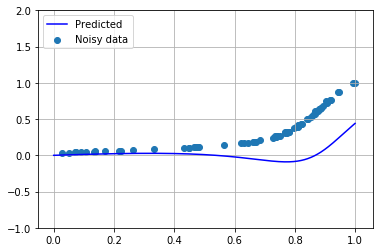

In [8]:
# TODO
# xp = ...
xp = np.linspace(0,1,1000)
# yhat = ...
yhat = predict(winit[0],xp)
# plot(...)
plt.plot(xp,yhat,'b',label='Predicted')
plt.scatter(xts,yts,label='Noisy data')
plt.ylim([-1,2])
plt.grid()
plt.legend(loc='upper left')
plt.show()

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

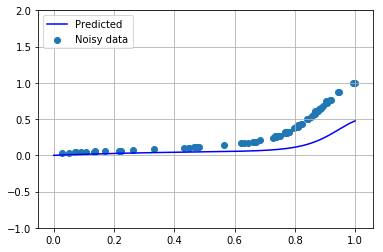

In [9]:
# TODO.  Fit with parameters with linear regression
# regr = Ridge(alpha=1e-3)
# regr.fit(...)
regr = Ridge(alpha=1e-3)
regr.fit(Z,ytr)
# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
# winit = ...
winit[0] = regr.coef_
winit[1] = regr.intercept_

# TODO
# Plot the results as above.
# xp = ...
xp = np.linspace(0,1,1000)
# yhat = ...
yhat = predict(winit[0],xp)
# plot(...)
plt.plot(xp,yhat,'b',label='Predicted')
plt.scatter(xts,yts,label='Noisy data')
plt.ylim([-1,2])
plt.grid()
plt.legend(loc='upper left')
plt.show()

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

$$f(w) = 0.5*\sum_i (y[i] - yhat[i])^2$$
    
and `fgrad`, the gradient of $f(w)$.

In [10]:
def feval(w,x,y):
    # TODO.  Parse w
    # a = ...
    # b = ...
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    # a = ...
    a = w[:d+1]
    # b = ...
    b = np.concatenate(([1],w[d+1:2*d+1]))
    
    # TODO.  Znum[i,j] = x[i]**j
    numerator = np.polyval(np.flip(a),x)
    
    # TODO.  Zden[i,j] = x[i]**(j+1)
    denominator = np.polyval(np.flip(b),x)
    
    # TODO.  Compute yhat 
    # Compute the numerator and denominator
    yhat = numerator / denominator
    
    # TODO.  Compute loss
    # f = ...
    error = (y-yhat)
    f = 0.5*np.sum(error**2)
    # TODO.  Compute gradients
    # Column vector
    X = np.reshape(x,(x.shape[0],1))
    # Copy column vector d times
    X = np.tile(X,d+1)
    # Power exponent
    p = np.array(range(d+1))
    # Power
    Xp = np.power(X,p)
    # Multiply by y
    Yp = -np.multiply(np.reshape(y,(y.shape[0],1)),Xp[:,1:])
    # TODO.  Create the transformed feature matrix
    # Z = ...
    Z = np.concatenate((Xp,Yp),axis=1)
    # fgrad = ...
    error = error/denominator
    fgrad = -(error.T.dot(Z))
    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
# TODO
w0 = winit[0]
# Perturb the point
step = 1e-6
w1 = w0 + step*np.random.randn(2*d+1)

# Measure the function and gradient at w0 and w1
f0, fgrad0 = feval(w0,xtr,ytr)
f1, fgrad1 = feval(w1,xtr,ytr)

# Predict the amount the function should have changed based on the gradient
df_est = fgrad0.dot(w1-w0)
# Print the two values to see if they are close
print("Actual f1-f0    = %12.4e" % (f1-f0))
print("Predicted f1-f0 = %12.4e" % df_est)

Actual f1-f0    =   4.7880e-04
Predicted f1-f0 =   3.5984e-04


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

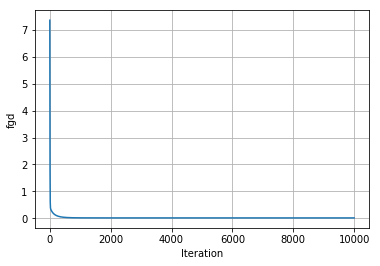

f0 =  0.01060063982559134
w =  [ 0.01600523  0.16461153 -0.34987447  0.22179376 -1.31996464 -0.28784387
  0.66033379]


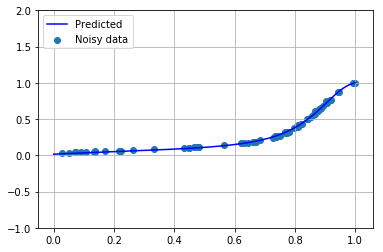

In [12]:
# TODO
class MyFun(object):
    def __init__(self,x,y):
        """
        Class for computes the loss and gradient for a logistic regression problem.
        
        The constructor takes the data matrix `X` and response vector y for training.
        """
        self.x = x
        self.y = y

    def feval(self,w):
        """
        Compute the loss and gradient for a given weight vector
        """
            # TODO.  Parse w
        # a = ...
        # b = ...
        # Get the length
        d = (len(w)-1)//2
    
        # TODO.  Extract a and b from w
        # a = ...
        a = w[:d+1]
        # b = ...
        b = np.concatenate(([1],w[d+1:2*d+1]))
    
        # TODO.  Znum[i,j] = x[i]**j
        numerator = np.polyval(np.flip(a),self.x)
    
        # TODO.  Zden[i,j] = x[i]**(j+1)
        denominator = np.polyval(np.flip(b),self.x)
    
        # TODO.  Compute yhat 
        # Compute the numerator and denominator
        yhat = numerator / denominator
    
        # TODO.  Compute loss
        # f = ...
        error = (self.y-yhat)
        f = 0.5*np.sum(error**2)
        # TODO.  Compute gradients
        # Column vector
        X = np.reshape(self.x,(self.x.shape[0],1))
        # Copy column vector d times
        X = np.tile(X,d+1)
        # Power exponent
        p = np.array(range(d+1))
        # Power
        Xp = np.power(X,p)
        # Multiply by y
        Yp = -np.multiply(np.reshape(self.y,(self.y.shape[0],1)),Xp[:,1:])
        # TODO.  Create the transformed feature matrix
        # Z = ...
        Z = np.concatenate((Xp,Yp),axis=1)
        # fgrad = ...
        error = error/denominator
        fgrad = -(error.T.dot(Z))
        return f, fgrad

def grad_opt_simp(feval, winit, lr=1e-3,nit=1000):
    """
    Simple gradient descent optimization
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    lr:     learning rate
    nit:    Number of iterations
    """
    # Initialize
    w0 = winit
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'w': [], 'f': []}
    
    # Loop over iterations
    for it in range(nit):

        # Evaluate the function and gradient
        f0, fgrad0 = feval(w0)

        # Take a gradient step
        w0 = w0 - lr*fgrad0
        
         # Save history
        hist['f'].append(f0)
        hist['w'].append(w0)

    # Convert to numpy arrays
    for elem in ('f', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f0, hist

myfun = MyFun(xtr,ytr)

# fgd = ...
nit = 10000
step = 1e-6
w0,f0,hist = grad_opt_simp(myfun.feval,winit[0],step,nit)
plt.figure()
plt.plot(hist.get('f'))
plt.xlabel('Iteration')
plt.ylabel('fgd')
plt.grid()
plt.show()
print('f0 = ', f0)
print('w = ', w0)
# xp = ...
xp = np.linspace(0,1,1000)
# yhat = ...
yhat = predict(w0,xp)
# plot(...)
plt.plot(xp,yhat,'b',label='Predicted')
plt.scatter(xts,yts,label='Noisy data')
plt.ylim([-1,2])
plt.grid()
plt.legend(loc='upper left')
plt.show()

Comments:
- The gradient descend algorithm converges and the coefficients represent better the data.

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

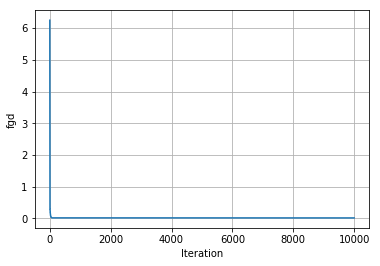

f0 =  0.010806024946805519
w =  [ 0.01503495  0.16527171 -0.34919662  0.22233367 -1.31937629 -0.28755109
  0.6603753 ]


In [13]:
# TODO
def grad_opt_adapt(feval, winit, lr_init=1e-3, nit=1000):
    """
    Gradient descent optimization with adaptive step size
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    nit:    Number of iterations
    lr:     Initial learning rate
    """
    
    # Set initial point
    w0 = winit
    f0, fgrad0 = feval(w0)
    lr = lr_init
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'lr': [], 'w': [], 'f': []}

    for it in range(nit):

        # Take a gradient step
        w1 = w0 - lr*fgrad0

        # Evaluate the test point by computing the objective function, f1,
        # at the test point and the predicted decrease, df_est
        f1, fgrad1 = feval(w1)
        df_est = fgrad0.dot(w1-w0)
        
        # Check if test point passes the Armijo condition
        alpha = 0.5
        if (f1-f0 < alpha*df_est) and (f1 < f0):
            # If descent is sufficient, accept the point and increase the
            # learning rate
            lr = lr*2
            f0 = f1
            fgrad0 = fgrad1
            w0 = w1
        else:
            # Otherwise, decrease the learning rate
            lr = lr/2            
            
        # Save history
        hist['f'].append(f0)
        hist['lr'].append(lr)
        hist['w'].append(w0)

    # Convert to numpy arrays
    for elem in ('f', 'lr', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f0, hist
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step
w0,f0,hist = grad_opt_adapt(myfun.feval,winit[0],step,nit)
plt.figure()
plt.plot(hist.get('f'))
plt.xlabel('Iteration')
plt.ylabel('fgd')
plt.grid()
plt.show()
print('f0 = ', f0)
print('w = ', w0)

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

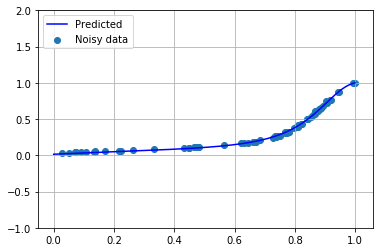

In [14]:
# TODO
# xp = np.linspace(...)
# yhat = ...
# plot(...)

# xp = ...
xp = np.linspace(0,1,1000)
# yhat = ...
yhat = predict(w0,xp)
# plot(...)
plt.plot(xp,yhat,'b',label='Predicted')
plt.scatter(xts,yts,label='Noisy data')
plt.ylim([-1,2])
plt.grid()
plt.legend(loc='upper left')
plt.show()

Comments:
- The Adaptive gradiend descend has a faster convergence than the gradient descend from previuos section.

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-5`.   Compare the convergence of the loss function with gradient descent.  

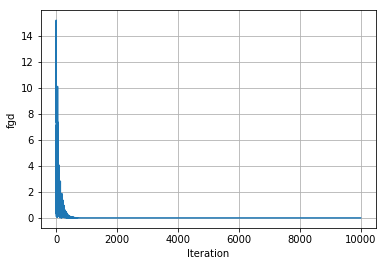

f0 =  0.01013093386149942
w =  [ 0.02559781  0.15059036 -0.36243567  0.2327152  -1.36001334 -0.25224907
  0.65945627]


In [15]:
# TODO
def grad_opt_momentum(feval, winit, beta, step=1e-5,nit=1000):
    """
    Simple gradient descent optimization
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    lr:     learning rate
    nit:    Number of iterations
    """
    # Initialize
    w0 = winit
    z = 0
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'w': [], 'f': []}
    
    # Loop over iterations
    for it in range(nit):

        # Evaluate the function and gradient
        f0, fgrad0 = feval(w0)
        # Take a gradient step
        z = beta*z + fgrad0
        w0 = w0 - step*z
        
        # Take a gradient step
        # w0 = w0 - lr*fgrad0
        
         # Save history
        hist['f'].append(f0)
        hist['w'].append(w0)

    # Convert to numpy arrays
    for elem in ('f', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f0, hist

nit = 10000
step = 1e-5  # Initial step
beta = 0.99
w0,f0,hist = grad_opt_momentum(myfun.feval,winit[0],beta,step,nit)
plt.figure()
plt.plot(hist.get('f'))
plt.xlabel('Iteration')
plt.ylabel('fgd')
plt.grid()
plt.show()
print('f0 = ', f0)
print('w = ', w0)

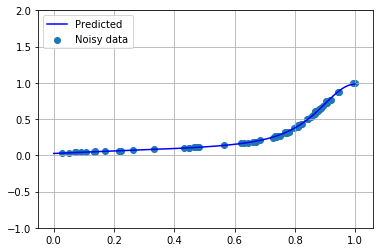

In [16]:
# TODO
# plot yhat vs. x
# xp = ...
xp = np.linspace(0,1,1000)
# yhat = ...
yhat = predict(w0,xp)
# plot(...)
plt.plot(xp,yhat,'b',label='Predicted')
plt.scatter(xts,yts,label='Noisy data')
plt.ylim([-1,2])
plt.grid()
plt.legend(loc='upper left')
plt.show()

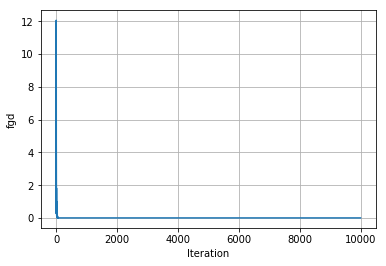

f0 =  0.01049405383425055
w =  [ 0.02501277  0.15012379 -0.35393155  0.22415236 -1.34203705 -0.28646367
  0.67460362]


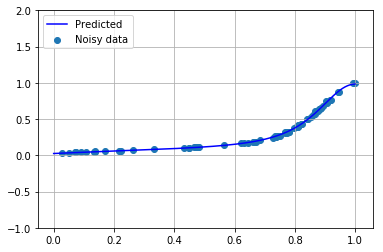

In [17]:
nit = 10000
step = 1e-5  # Initial step
beta = 0.9
w0,f0,hist = grad_opt_momentum(myfun.feval,winit[0],beta,step,nit)
plt.figure()
plt.plot(hist.get('f'))
plt.xlabel('Iteration')
plt.ylabel('fgd')
plt.grid()
plt.show()
print('f0 = ', f0)
print('w = ', w0)
# plot yhat vs. x
# xp = ...
xp = np.linspace(0,1,1000)
# yhat = ...
yhat = predict(w0,xp)
# plot(...)
plt.plot(xp,yhat,'b',label='Predicted')
plt.scatter(xts,yts,label='Noisy data')
plt.ylim([-1,2])
plt.grid()
plt.legend(loc='upper left')
plt.show()

Comments:
- Momentum Gradient Descend can speed up the algorithm convergence, but the beta value has to be less than the propossed value (beta=0.99) to avoid unstabilities at the begining of the algorithm.

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.